<a href="https://colab.research.google.com/github/ArkanEmre/AI-Based-Retail-Product-Identification/blob/master/GroceryStoreDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6553, done.
remote: Total 6553 (delta 0), reused 0 (delta 0), pack-reused 6553
Receiving objects: 100% (6553/6553), 116.24 MiB | 32.74 MiB/s, done.
Resolving deltas: 100% (313/313), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import tarfile
from google.colab import drive
import os
import pandas as pd
import csv
from shutil import copyfile, copy2, copy
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from numpy import argmax
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from keras_preprocessing.image import ImageDataGenerator
from textwrap import wrap
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC, CategoricalCrossentropy
from tensorflow_addons.metrics import F1Score
import json
import datetime
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import itertools

In [4]:
dataset_path = '/content/GroceryStoreDataset/dataset'

classes_df = pd.read_csv('/content/GroceryStoreDataset/dataset/classes.csv', sep=',', header=0).loc[:, ['Class ID (int)', 'Class Name (str)']]

train_df = pd.read_csv('/content/GroceryStoreDataset/dataset/train.txt', sep=',', header=None)
train_df.columns = ["file_path", "label", "superclass_label"]
train_df = train_df.loc[:, ["file_path", "label"]]

for i, row in train_df.iterrows():
  train_df.loc[i,'label'] =  classes_df.iloc[row['label']][1]

validation_df = pd.read_csv('/content/GroceryStoreDataset/dataset/val.txt', sep=',', header=None)
validation_df.columns = ["file_path", "label", "superclass_label"]
validation_df = validation_df.loc[:, ["file_path", "label"]]

for i, row in validation_df.iterrows():
  validation_df.loc[i,'label'] =  classes_df.iloc[row['label']][1]

evaluation_df = pd.read_csv('/content/GroceryStoreDataset/dataset/test.txt', sep=',', header=None)
evaluation_df.columns = ["file_path", "label", "superclass_label"]
evaluation_df = evaluation_df.loc[:, ["file_path", "label"]]

for i, row in evaluation_df.iterrows():
  evaluation_df.loc[i,'label'] =  classes_df.iloc[row['label']][1]

In [6]:
dataset_df = pd.concat([train_df, validation_df, evaluation_df])

train_validate_filenames, evaluation_filenames, train_validate_labels, evaluation_labels = train_test_split(dataset_df['file_path'], dataset_df['label'], train_size=0.8, random_state=42, stratify=dataset_df['label'])

train_validate_df = pd.DataFrame(zip(train_validate_filenames, train_validate_labels), columns=['file_path', 'label'])

train_filenames, validation_filenames, train_labels, validation_labels = train_test_split(train_validate_df['file_path'], train_validate_df['label'], train_size=0.875, random_state=42, stratify=train_validate_df['label'])

train_df = pd.DataFrame(zip(train_filenames, train_labels), columns=['file_path', 'label'])

validation_df = pd.DataFrame(zip(validation_filenames, validation_labels), columns=['file_path', 'label'])

evaluation_df = pd.DataFrame(zip(evaluation_filenames, evaluation_labels), columns=['file_path', 'label'])

## Defining data augmentations

Found 3794 validated image filenames belonging to 81 classes.
Found 542 validated image filenames belonging to 81 classes.
Found 1085 validated image filenames belonging to 81 classes.


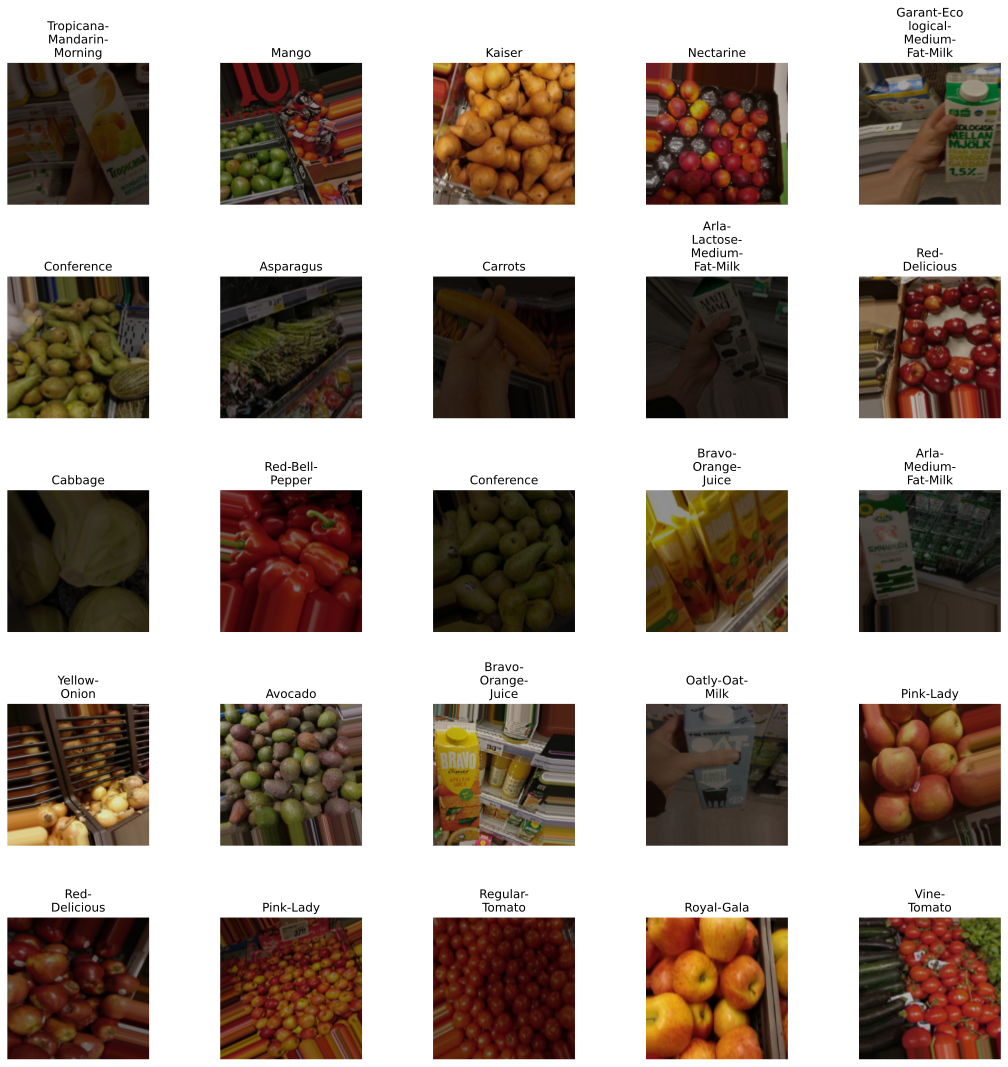

In [20]:
IMG_SIZE = 256
BATCH_SIZE = 128

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=30,  
    zoom_range = 0.2,
    shear_range = 0.2,
    width_shift_range=0.2,  
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=False,  
    vertical_flip=False,
    rescale=1. / 255)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

evaluation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=dataset_path, x_col="file_path", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=validation_df, directory=dataset_path, x_col="file_path", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

evaluation_generator  = evaluation_datagen.flow_from_dataframe(dataframe=evaluation_df, directory=dataset_path, x_col="file_path", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

class_indices = evaluation_generator.class_indices
class_indices_inverted = {v: k for k, v in class_indices.items()}

x,y = train_generator.next()

fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
num = 0
for i in range(5):
  for j in range (5):
    ax[i,j].imshow(x[num])
    mydict = evaluation_generator.class_indices
    inverted = list(mydict.keys())[list(mydict.values()).index(argmax(y[num]))]
    ax[i,j].set_title("\n".join(wrap(inverted, 10)))
    ax[i,j].axis('off')
    num += 1
  num += 1
        
plt.tight_layout()

## Defining the Model

In [8]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet',
                                         )
base_model.trainable = False

219062272/219055592 [==============================] - 2s 0us/step


In [9]:
global_max_layer = tf.keras.layers.GlobalMaxPooling2D()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.4)
dense_layer_1 = tf.keras.layers.Dense(128, activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.0001))
leaky_relu_layer = tf.keras.layers.LeakyReLU()
dense_layer_2 = tf.keras.layers.Dense(81)
activation_layer = tf.keras.layers.Activation('softmax', dtype='float64', name='output')

In [10]:
num_classes = len(train_generator.class_indices)
metrics = [CategoricalAccuracy(name='categorical_accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    CategoricalCrossentropy(label_smoothing=0.3),
    F1Score(name='f1score',num_classes=num_classes)]

In [11]:
model = tf.keras.Sequential([
  base_model,
  global_max_layer,
  dropout_layer,
  dense_layer_2,
  activation_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_max_pooling2d (Global (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 81)                124497    
_________________________________________________________________
output (Activation)          (None, 81)                0         
Total params: 54,461,233
Trainable params: 124,497
Non-trainable params: 54,336,736
_________________________________________________________________


## Training the Model

In [ ]:
num_epochs = 100

history = model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator)

Epoch 1/100
30/30 [==============================] - 72s 2s/step - loss: 2.0793 - categorical_accuracy: 0.4823 - precision: 0.5803 - recall: 0.4141 - auc: 0.9316 - categorical_crossentropy: 4.9600 - f1score: 0.4815 - val_loss: 1.1691 - val_categorical_accuracy: 0.6697 - val_precision: 0.8222 - val_recall: 0.5461 - val_auc: 0.9802 - val_categorical_crossentropy: 4.0731 - val_f1score: 0.6584
Epoch 2/100
30/30 [==============================] - 73s 2s/step - loss: 2.1162 - categorical_accuracy: 0.4655 - precision: 0.5757 - recall: 0.4017 - auc: 0.9298 - categorical_crossentropy: 4.9802 - f1score: 0.4645 - val_loss: 1.1894 - val_categorical_accuracy: 0.6771 - val_precision: 0.8060 - val_recall: 0.5443 - val_auc: 0.9800 - val_categorical_crossentropy: 4.0943 - val_f1score: 0.6678
Epoch 3/100
30/30 [==============================] - 72s 2s/step - loss: 2.0626 - categorical_accuracy: 0.4802 - precision: 0.5802 - recall: 0.4120 - auc: 0.9329 - categorical_crossentropy: 4.9705 - f1score: 0.4759

## Evaluation

In [ ]:
model.evaluate(evaluation_generator)

9/9 [==============================] - 6s 690ms/step - loss: 0.8136 - categorical_accuracy: 0.7493 - precision: 0.8542 - recall: 0.6424 - auc: 0.9887 - categorical_crossentropy: 4.1722 - f1score: 0.7548


[0.8136342763900757,
 0.7493087649345398,
 0.8541666865348816,
 0.6423963308334351,
 0.9886960387229919,
 4.172237396240234,
 array([0.6363636 , 0.5555555 , 0.6206897 , 0.5555556 , 0.73333335,
        0.76190484, 0.8000001 , 0.90909094, 0.6857143 , 0.71428573,
        0.6666667 , 0.74285716, 0.85714287, 0.8571428 , 0.8       ,
        0.93333334, 1.        , 0.8648649 , 0.972973  , 0.94117653,
        0.8000001 , 0.9230769 , 0.83333343, 0.94117653, 0.8666667 ,
        0.94117653, 0.9142857 , 0.78571427, 0.46153846, 0.74999994,
        0.8000001 , 0.75      , 0.82352936, 0.875     , 0.90000004,
        0.6666667 , 0.63157904, 0.47058827, 0.17391305, 0.6956521 ,
        0.81818175, 0.8484849 , 0.66666675, 0.61538464, 1.        ,
        0.71428573, 0.5       , 0.64000005, 0.85714287, 0.9032258 ,
        0.7586207 , 0.5641026 , 0.5555556 , 0.8235294 , 0.6       ,
        0.85714287, 0.95652175, 0.5882353 , 0.90000004, 0.6363636 ,
        1.        , 0.64285713, 0.73684216, 0.56250006, 0.8

In [30]:
# from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues, file_name='confusion_matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(32,32))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join('/content', file_name) + '.svg')

In [22]:
def get_image (path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    x = np.array(img).astype('float32')/255
    x = np.expand_dims(x, axis=0)
    return x

In [23]:
class_numbers_predicted = []
class_numbers_actual = []

labels_ = evaluation_df.groupby("label")
for label in labels_:
  for path in label[1]["file_path"]:
    x = get_image(os.path.join(dataset_path, path))
    p = model.predict(x)
    predicted = class_indices_inverted[argmax(p)]
    class_numbers_predicted.append(argmax(p))
    actual = label[0]
    class_numbers_actual.append(class_indices[actual])

Confusion matrix, without normalization


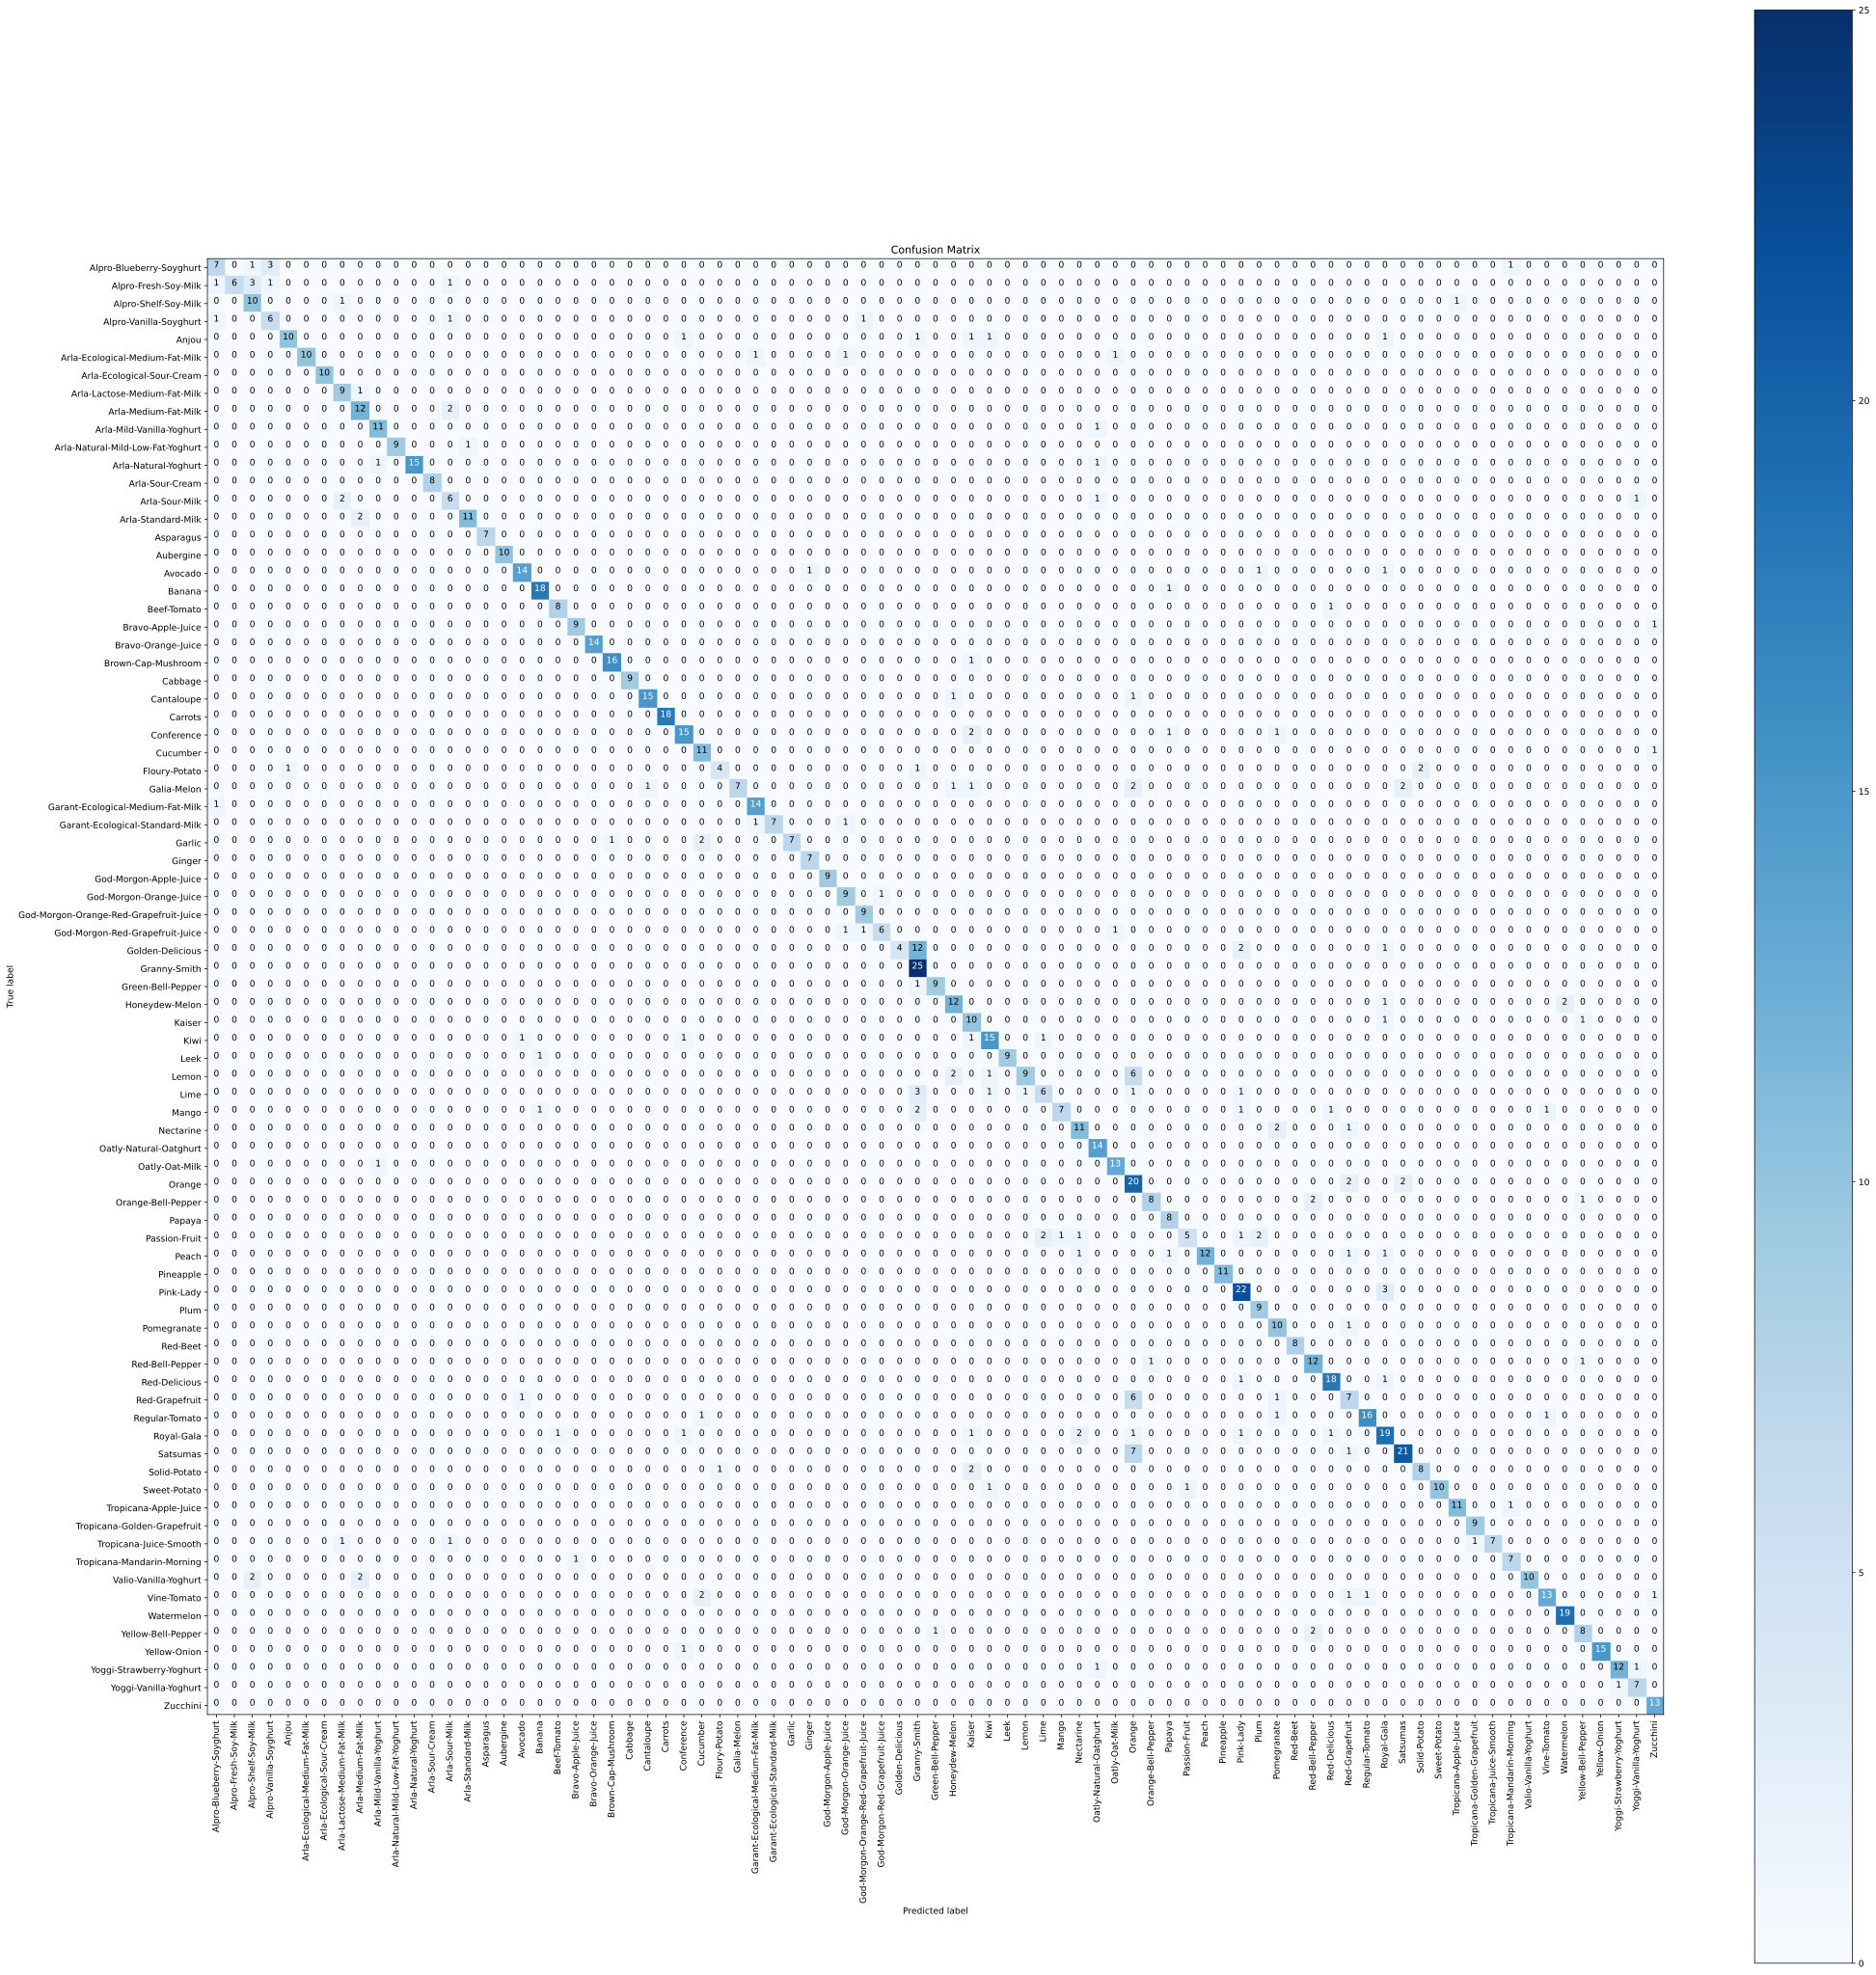

In [31]:
cm = confusion_matrix(y_true=class_numbers_actual, y_pred=class_numbers_predicted)
cm_plot_labels = evaluation_generator.class_indices
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix', file_name='confusion_matrix_GroceryStoreDataset')

## Save and Load Model & Results

In [ ]:
date_str_now = datetime.datetime.now().strftime("%d_%m_%y_%H_%M_%S")

#model_path =  '/content/drive/My Drive/Colab Notebooks/models/freiburg_groceries/InceptionResNetV2_imagenet_{}.h5'.format(date_str_now)
#model.save(model_path) 
model.load_weights('/content/drive/My Drive/Colab Notebooks/models/freiburg_groceries/InceptionResNetV2_imagenet_29_06_20_17_17_02.h5')

In [13]:
hist_df = pd.DataFrame(history.history) 

# save history to json:  
hist_json_file = '/content/drive/My Drive/Colab Notebooks/models/freiburg_groceries/history/InceptionResNetV2_{}_history.json'.format(date_str_now)
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)